<h1><center>Jigsaw Unintended Bias in Toxicity Classification</center></h1>
<h2><center>Detect toxicity across a diverse range of conversations</center></h2>

#### In this competition we need to detect toxic comments and minimize unintended model bias, for this we to optimizing a metric designed to measure unintended bias, and we are provided a ~2 million dataset labeled for identity mentions

#### Problem background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where, unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

##### Content:
- [Data overview](#First-let's-take-a-quick-look-at-the-data)
- [EDA](#EDA)
- [Target distribution](#Target-distribution-[toxicity])
- [Toxicity overtime](#Let's-take-a-look-at-how-the-comment-toxicity-behaves-overtime)
- [Toxicity by group](#Toxicity-rate-dsitribution-for-each-super-group-[race,-religion,-type,-etc...])
- [Top 60 Most frequent word on toxic comments](#Top-60-Most-frequent-word-on-toxic-comments)
- [Toxic comments word clouds](#Toxic-comments-frequency)
- [Hypotesis validation](#Hypotesis)






### Dependencies

In [1]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from altair.vega import v3
from IPython.display import HTML
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
alt.data_transformers.enable('default', max_rows=None)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


In [2]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

### Load data

In [3]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

### First let's take a quick look at the data

In [4]:
total_comments = train.shape[0]
n_unique_comments = train['comment_text'].nunique()
n_comments_both = len(set(train['comment_text'].unique()) & set(test['comment_text'].unique()))
print('Train set: %d rows and %d columns.' % (total_comments, train.shape[1]))
display(train.head())
display(train.describe())
print('Test set: %d rows and %d columns.' % (test.shape[0], test.shape[1]))
display(test.head())
print('Number of unique comments: %d or %.2f%%'% (n_unique_comments, (n_unique_comments / total_comments * 100)))
print('Number of comments that are both in train and test sets: %d'% n_comments_both)

Train set: 1804874 rows and 45 columns.


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0000,"This is so cool. It's like, 'would you want yo...",0.0000,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2015-09-29 10:50:41.987077+00,2,nan,2006,rejected,0,0,0,0,0,0.0000,0,4
1,59849,0.0000,Thank you!! This would make my life a lot less...,0.0000,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2015-09-29 10:50:42.870083+00,2,nan,2006,rejected,0,0,0,0,0,0.0000,0,4
2,59852,0.0000,This is such an urgent design problem; kudos t...,0.0000,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2015-09-29 10:50:45.222647+00,2,nan,2006,rejected,0,0,0,0,0,0.0000,0,4
3,59855,0.0000,Is this something I'll be able to install on m...,0.0000,0.0000,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2015-09-29 10:50:47.601894+00,2,nan,2006,rejected,0,0,0,0,0,0.0000,0,4
4,59856,0.8936,haha you guys are a bunch of losers.,0.0213,0.0000,0.0213,0.8723,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2015-09-29 10:50:48.488476+00,2,nan,2006,rejected,0,0,0,1,0,0.0000,4,47


,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,405130.0000,1804874.0000,1026228.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000,1804874.0000
mean,3738433.7911,0.1030,0.0046,0.0139,0.0226,0.0812,0.0093,0.0120,0.0032,0.0019,0.0344,0.0014,0.0953,0.1277,0.0032,0.0015,0.0256,0.0011,0.0179,0.0061,0.1087,0.0495,0.0012,0.0009,0.0082,0.0068,0.0015,0.0014,0.0121,0.0067,0.0570,49.8630,3722687.0605,281359.7132,0.2779,0.0442,0.1091,2.4462,0.5844,0.0066,1.4390,8.7847
std,2445186.7634,0.1971,0.0229,0.0646,0.0787,0.1761,0.0494,0.0872,0.0502,0.0261,0.1679,0.0309,0.2567,0.3054,0.0458,0.0309,0.1437,0.0160,0.1221,0.0587,0.2679,0.2025,0.0141,0.0119,0.0427,0.0375,0.0154,0.0175,0.0892,0.0690,0.2160,27.6987,2450261.2127,103929.2785,1.0553,0.2449,0.4555,4.7279,1.8666,0.0453,17.8704,43.5009
min,59848.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,61006.0000,2006.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
25%,796975.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,21.0000,796018.7500,160120.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000
50%,5223774.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,54.0000,5222993.0000,332126.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,4.0000
75%,5769854.5000,0.1667,0.0000,0.0000,0.0000,0.0909,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,54.0000,5775757.5000,366237.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.0000,6.0000
max,6334010.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.6000,0.7500,1.0000,1.0000,0.7500,1.0000,1.0000,1.0000,1.0000,115.0000,6333965.0000,399541.0000,102.0000,21.0000,31.0000,300.0000,187.0000,1.0000,1866.0000,4936.0000


Test set: 97320 rows and 2 columns.


,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


Number of unique comments: 1780823 or 98.67%
Number of comments that are both in train and test sets: 1170


## EDA

### Distribution of comment length

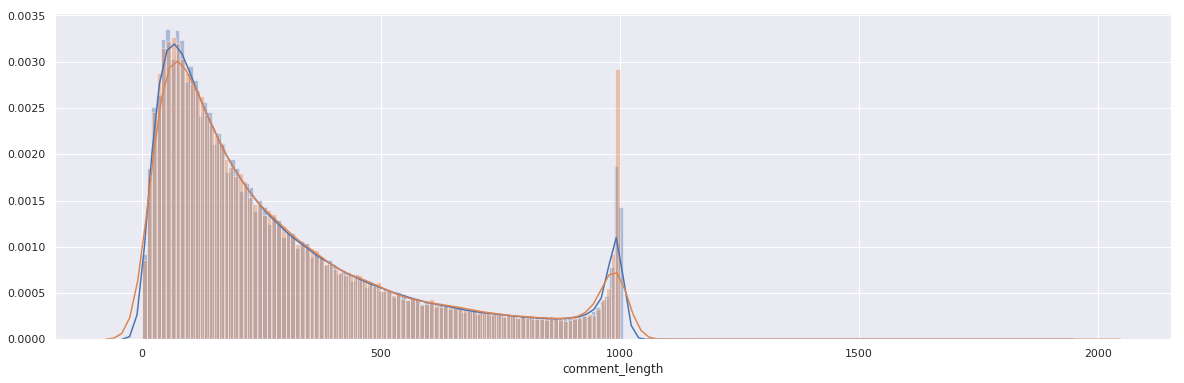

In [5]:
train['comment_length'] = train['comment_text'].apply(lambda x : len(x))
test['comment_length'] = test['comment_text'].apply(lambda x : len(x))
train['word_count'] = train['comment_text'].apply(lambda x : len(x.split(' ')))
test['word_count'] = test['comment_text'].apply(lambda x : len(x.split(' ')))
bin_size = max(train['comment_length'].max(), test['comment_length'].max())//10

plt.figure(figsize=(20, 6))
sns.distplot(train['comment_length'], bins=bin_size)
sns.distplot(test['comment_length'], bins=bin_size)
plt.show()

We can see a peak at 1000 length, maybe this is because of where data was sampled from (Twitter have max size of characters), this happen both on train and test set.

### Distribution of comment word count

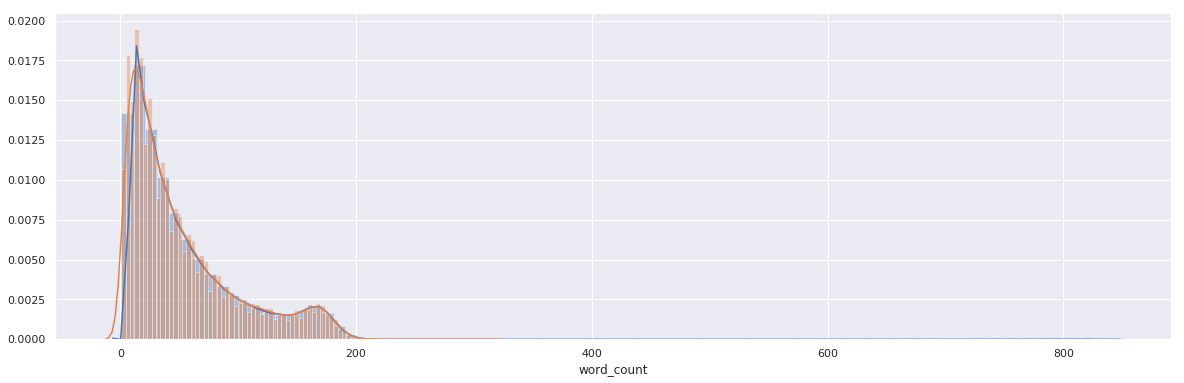

In [6]:
bin_size = max(train['word_count'].max(), test['word_count'].max())//10
plt.figure(figsize=(20, 6))
sns.distplot(train['word_count'], bins=bin_size)
sns.distplot(test['word_count'], bins=bin_size)
plt.show()

- Most of the comments are small (less than 200 characters)
- Also in regard of comment length and word count, train and test sets have a similar distribution.

### Target distribution [toxicity]

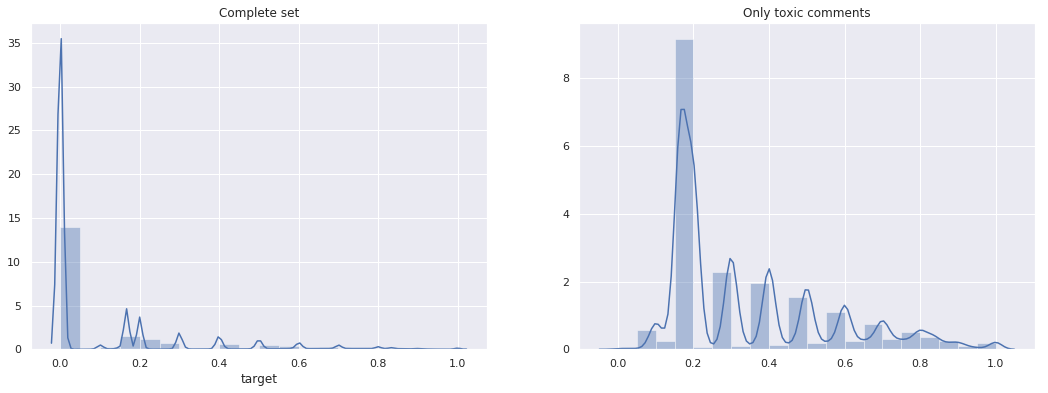

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.distplot(train['target'], bins=20, ax=ax1).set_title("Complete set")
sns.distplot(train[train['target'] > 0]['target'].values, bins=20, ax=ax2).set_title("Only toxic comments")
plt.show()

- Most of the comments are not toxic
- On the toxic comments most of them are not "highly toxic" (target around 0.2)

### Target distribution (toxic and non-toxic (toxic >= 0.5))

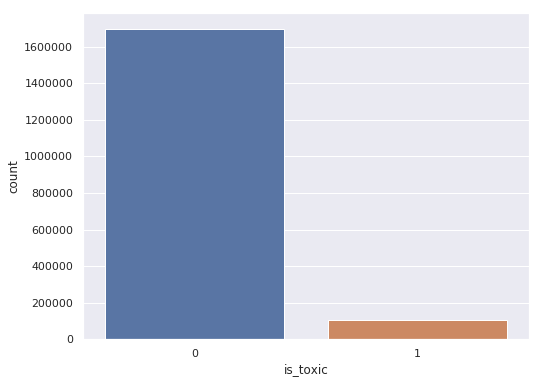

In [8]:
train['is_toxic'] = train['target'].apply(lambda x : 1 if (x > 0.5) else 0)
plt.figure(figsize=(8, 6))
sns.countplot(train['is_toxic'])
plt.show()

As one would expect the data is heavily imbalanced, this makes sense since it mirror the real world.

### Let's take a look at how the comment toxicity behaves overtime

In [9]:
HEIGHT = 300
WIDTH = 600
train['created_date'] = pd.to_datetime(train['created_date']).values.astype('datetime64[M]')
target_df = train.sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count'], 'target':['mean']})
target_df.columns = ['Date', 'Count', 'Toxicity rate']

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['created_date'], empty='none')

rate_line = alt.Chart().mark_line(interpolate='basis', color='red').encode(
    x='Date:T',
    y='Toxicity rate:Q'
).interactive()

# The basic line
count_line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q'
).properties(title="Counts and rate of toxicity comments").interactive()

render(alt.layer(rate_line, count_line, data=target_df, width=WIDTH, height=HEIGHT).resolve_scale(
    y='independent'
))

> - Red = toxicity rate
> - Blue = Comment count

- One interesting point is that on November 2015 the comments were mostly non-toxic, but after that the toxicity just increased and remained stable after July 2016.
- As we can see the comment count increased as time increase but droped after October 2017, maybe some of those comments are on the test set.

### Now let's see on a more detailed level, looking at each group.

### Number of toxic comments for each group

In [10]:
disability_gp = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
disability_df = train[train[disability_gp[0]] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
disability_df.columns = ['Date', disability_gp[0]]

for x in disability_gp[1:]:
    df = train[train[x] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
    df.columns = ['Date', x]
    disability_df = pd.merge(disability_df, df)

disability_df = disability_df.melt('Date', var_name='category', value_name='Count').sort_values('Date')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q',
    color='category:N'
).properties(title="Counts of disability related toxic comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='Date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=disability_df, width=WIDTH, height=HEIGHT))

In [11]:
race_gp = ['asian', 'black', 'latino', 'other_race_or_ethnicity', 'white']
race_df = train[train[race_gp[0]] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
race_df.columns = ['Date', race_gp[0]]

for x in race_gp[1:]:
    df = train[train[x] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
    df.columns = ['Date', x]
    race_df = pd.merge(race_df, df)

race_df = race_df.melt('Date', var_name='category', value_name='Count').sort_values('Date')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q',
    color='category:N'
).properties(title="Counts of race related toxic comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='Date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=race_df, width=WIDTH, height=HEIGHT))

In [12]:
religion_gp = ['atheist', 'buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'other_religion']
religion_df = train[train[religion_gp[0]] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
religion_df.columns = ['Date', religion_gp[0]]

for x in religion_gp[1:]:
    df = train[train[x] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
    df.columns = ['Date', x]
    religion_df = pd.merge(religion_df, df)

religion_df = religion_df.melt('Date', var_name='category', value_name='Count').sort_values('Date')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q',
    color='category:N'
).properties(title="Counts of religion related toxic comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='Date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=religion_df, width=WIDTH, height=HEIGHT))

In [13]:
gender_gp = ['bisexual', 'female', 'heterosexual',  'homosexual_gay_or_lesbian', 'male', 'other_gender', 'other_sexual_orientation', 'transgender']
gender_df = train[train[gender_gp[0]] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
gender_df.columns = ['Date', gender_gp[0]]

for x in gender_gp[1:]:
    df = train[train[x] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
    df.columns = ['Date', x]
    gender_df = pd.merge(gender_df, df)

gender_df = gender_df.melt('Date', var_name='category', value_name='Count').sort_values('Date')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q',
    color='category:N'
).properties(title="Counts of gender & orientation related toxic comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='Date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=gender_df, width=WIDTH, height=HEIGHT))

### Number of toxic comments of each type

In [14]:
toxicity_gp = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat' , 'sexual_explicit']
toxicity_df = train[train[toxicity_gp[0]] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
toxicity_df.columns = ['Date', toxicity_gp[0]]

for x in toxicity_gp[1:]:
    df = train[train[x] > 0].sort_values('created_date').groupby('created_date', as_index=False).agg({'id':['count']})
    df.columns = ['Date', x]
    toxicity_df = pd.merge(toxicity_df, df)

toxicity_df = toxicity_df.melt('Date', var_name='category', value_name='Count').sort_values('Date')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Date'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='Date:T',
    y='Count:Q',
    color='category:N'
).properties(title="Counts of toxic type comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='Date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Count:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='Date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=toxicity_df, width=WIDTH, height=HEIGHT))

Most of the sub-groups comment count increase overtime then drop close to the end, also its good to know which specific kind has higher or lower count.

### Toxicity rate dsitribution for each super group [race, religion, type, etc...]

In [15]:
# Got this from here https://www.kaggle.com/artgor/toxicity-eda-model-interpretation-and-more/data
train['disability'] = train['intellectual_or_learning_disability'] + train['other_disability'] + train['physical_disability'] + train['psychiatric_or_mental_illness']
train['race'] = train['asian'] + train['black'] + train['latino'] + train['other_race_or_ethnicity'] + train['white']
train['religion'] = train['atheist'] + train['buddhist'] + train['christian'] + train['hindu'] + train['jewish'] + train['muslim'] + train['other_religion']
train['gender'] = train['bisexual'] + train['female'] + train['heterosexual'] + train['homosexual_gay_or_lesbian'] + train['male'] + train['other_gender'] + train['other_sexual_orientation'] + train['transgender']
train['type'] = train['severe_toxicity'] + train['obscene'] + train['identity_attack'] + train['insult'] + train['threat'] + train['sexual_explicit']
super_groups_gp = ['disability', 'race', 'religion', 'gender', 'type']
plot_dict = {}
bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 1]

for col in super_groups_gp:
    df_ = train.loc[train[col] > 0]
    hist_df = pd.cut(df_[col], bins).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
    hist_df['bins'] = hist_df['bins'].astype(str)
    plot_dict[col] = alt.Chart(hist_df).mark_bar().encode(
        x=alt.X("bins:O", axis=alt.Axis(title='Target bins')),
        y=alt.Y(f'{col}:Q', axis=alt.Axis(title='Count')),
        tooltip=[col, 'bins']
    ).properties(title=f"Distribution of {col}", width=300, height=200).interactive()
    
render((plot_dict['disability'] | plot_dict['race']) & (plot_dict['religion'] | plot_dict['gender']) & (plot_dict['type']))

Comments related to disability seem to be less toxic than the other groups.

### Would be nice to see the distribution of the actual words used on the comments, this may give us some insights.

### Top 60 Most frequent word on toxic comments

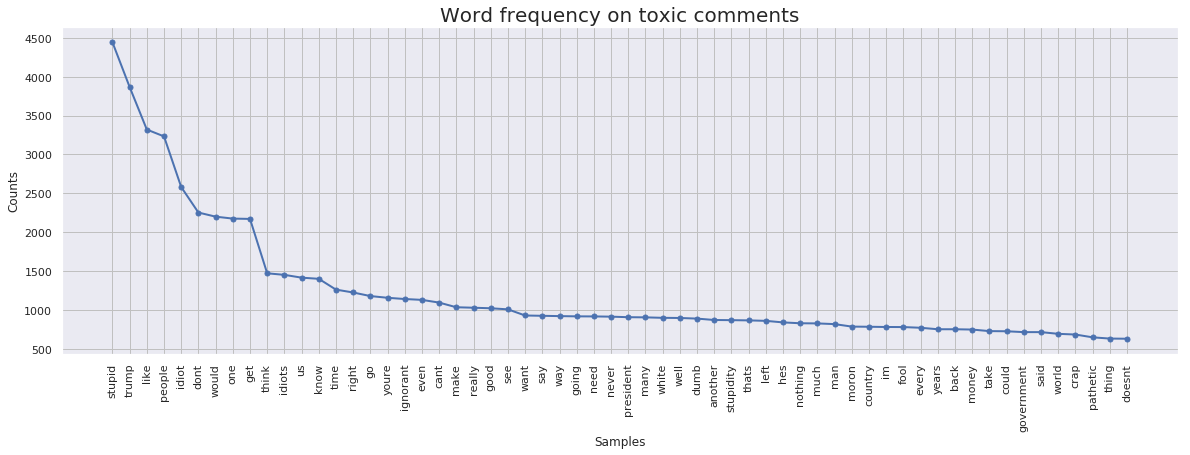

In [16]:
eng_stopwords = stopwords.words('english')
train['comment_text'] = train['comment_text'].apply(lambda x: x.lower())
# train['comment_text'] = train['comment_text'].str.replace('[^\w\s]','')
train['comment_text'] = train['comment_text'].str.replace('[^a-z ]','')
train['comment_text'] = train['comment_text'].apply(lambda x: " ".join(x for x in x.split() if x not in eng_stopwords))

freq_dist = FreqDist([word for comment in train[train['target'] > 0.8]['comment_text'] for word in comment.split()])

plt.figure(figsize=(20, 6))
plt.title('Word frequency on toxic comments').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

### Toxic comments frequency

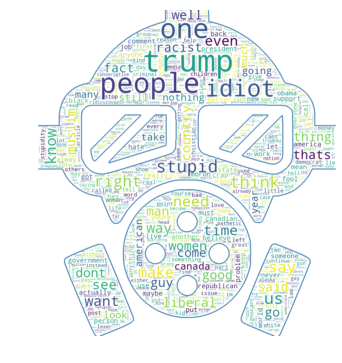

In [17]:
wc_stopwords = set(STOPWORDS)
def plot_WordCloud(group, mask_path):
    mask = np.array(Image.open(mask_path))[:,:,1]
    text = train[train[group] > 0.8 ]['comment_text'].values
    wc = WordCloud(background_color="white", max_words=2000, mask=mask,
                   stopwords=wc_stopwords, contour_width=3, contour_color='steelblue')

    wc.generate(" ".join(text))

    plt.figure(figsize=(6, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

plot_WordCloud(group='type', mask_path="../input/toxicity-comments-images/toxic1.png")

### Racial toxic comments frequency

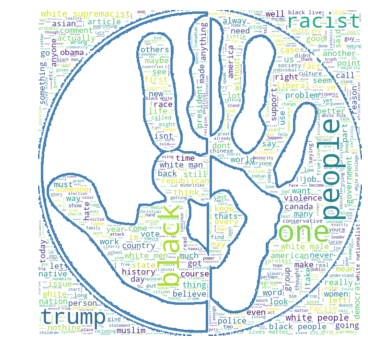

In [18]:
plot_WordCloud(group='race', mask_path="../input/toxicity-comments-images/race.png")

### Disability toxic comments frequency

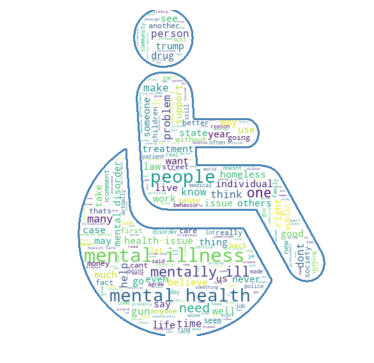

In [19]:
plot_WordCloud(group='disability', mask_path="../input/toxicity-comments-images/disability3.png")

### Gender toxic comments frequency

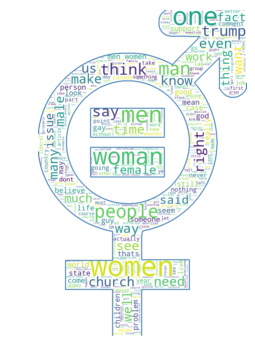

In [20]:
plot_WordCloud(group='gender', mask_path="../input/toxicity-comments-images/gender2.png")

### Religion toxic comments frequency

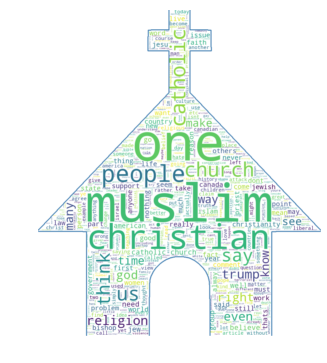

In [21]:
plot_WordCloud(group='religion', mask_path="../input/toxicity-comments-images/religion1.png")

## Hypotesis
- When we are dealing with a database it's always good to validate any hypotesis that we might have and could impact the problem.

### Does smaller comments have more raters?
- At first I thought that smaller comments may have more raters as they are simpler and faster to rate, this may increase their rating confidence, lets see.

In [22]:
annotators_len_df = train[train['identity_annotator_count'] > 0].groupby('word_count', as_index=False).agg({'identity_annotator_count': 'mean'})
annotators_len_df.columns = ['word_count', 'mean_annotators']

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['word_count'], empty='none')

# The basic line
line = alt.Chart().mark_line().encode(
    y='mean_annotators:Q',
    x='word_count:Q'
).properties(title="Counts of toxic type comments")

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='word_count:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'mean_annotators:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='word_count:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
render(alt.layer(line, selectors, points, rules, text, data=annotators_len_df, width=WIDTH, height=HEIGHT))

So it seems that the word count doens't really matter, most comments that have annotators have a mean around 4, with some spikes.

## Model

- [From this article](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)
> Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.
> 
> In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

In [23]:
X_train = train['comment_text'].astype(str)
X_test = test['comment_text'].astype(str)
y = np.where(train['target'] >= 0.5, True, False) * 1

In [24]:
num_words = 20000
max_len = 150
emb_size = 128

In [25]:
tok = Tokenizer(num_words = num_words)
tok.fit_on_texts(list(X_train))

In [26]:
X = tok.texts_to_sequences(X_train)
test = tok.texts_to_sequences(X_test)

In [27]:
X = sequence.pad_sequences(X, maxlen=max_len)
X_test = sequence.pad_sequences(test, maxlen=max_len)

In [28]:
# Got this model here: https://www.kaggle.com/lsjsj92/toxic-simple-eda-and-modeling-with-lstm
inp = Input(shape = (max_len, ))
layer = Embedding(num_words, emb_size)(inp)
layer = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.15))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)

model = Model(inputs=inp, outputs=layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          71600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)      

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X, y, batch_size=1024, epochs=20, validation_split=0.2, callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/20
1443899/1443899 [==============================] - 746s 516us/step - loss: 0.1588 - acc: 0.9444 - val_loss: 0.1461 - val_acc: 0.9449
Epoch 2/20
1443899/1443899 [==============================] - 740s 512us/step - loss: 0.1338 - acc: 0.9499 - val_loss: 0.1464 - val_acc: 0.9449
Epoch 3/20
1443899/1443899 [==============================] - 733s 508us/step - loss: 0.1262 - acc: 0.9524 - val_loss: 0.1495 - val_acc: 0.9446
Epoch 4/20
1443899/1443899 [==============================] - 730s 506us/step - loss: 0.1178 - acc: 0.9552 - val_loss: 0.1538 - val_acc: 0.9435
Epoch 00004: early stopping


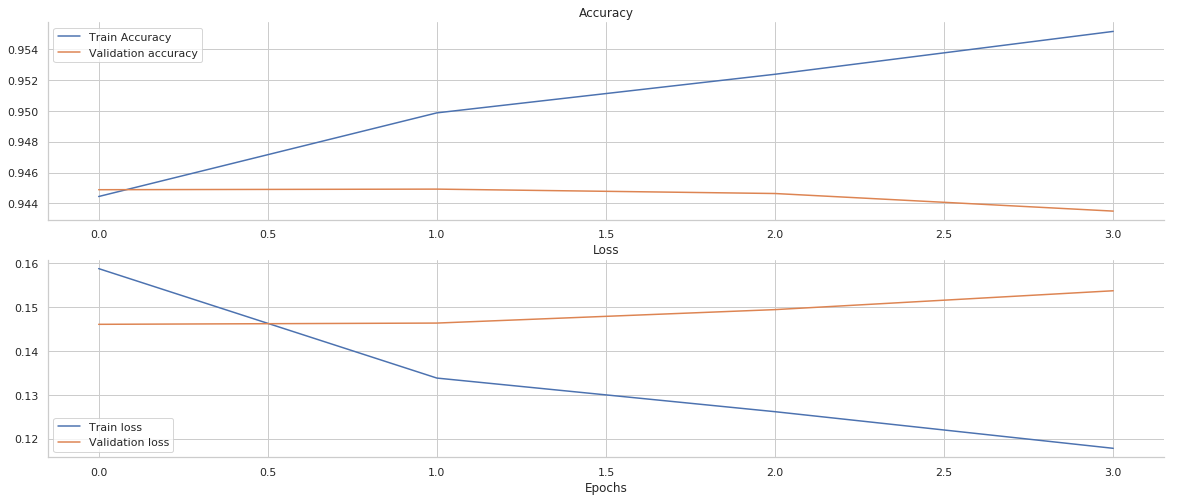

In [30]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

ax1.plot(history.history['acc'], label='Train Accuracy')
ax1.plot(history.history['val_acc'], label='Validation accuracy')
ax1.legend(loc='best')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('Loss')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [31]:
Y_test = model.predict(X_test)

In [32]:
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')
submission['prediction'] = Y_test
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,prediction
0,7000000,0.0066
1,7000001,0.0002
2,7000002,0.0009
3,7000003,0.0002
4,7000004,0.9492
5,7000005,0.0005
6,7000006,0.0007
7,7000007,0.0008
8,7000008,0.0002
9,7000009,0.0028
